# Testfield for drawing

In [1]:
import duckdb as dd
import pandas as pd
from duck_tools import *
import numpy as np
import matplotlib.pyplot as plt

## Read data to df


In [51]:
#Käytä Silver-databasea
tbl = "Silver_SensorData"
#Valitse node
node = "3200"

df = read_node(tbl, node)
df


,node_id,timestamp,x,y
0,3200,2019-03-07 13:46:19.078016,0,0
1,3200,2019-03-07 13:46:20.078012,0,0
2,3200,2019-03-07 13:46:21.078081,0,0
3,3200,2019-03-07 13:46:22.078130,0,0
4,3200,2019-03-14 11:57:31.687637,228,1084
...,...,...,...,...
1040750,3200,2020-01-22 19:53:24.478754,311,1349
1040751,3200,2020-01-22 19:53:28.478973,265,1187
1040752,3200,2020-01-22 19:53:28.478998,265,1187
1040753,3200,2020-01-22 19:53:32.478699,253,1143


In [117]:
## Datan putkitus ja testaus
### Säädä tässä parametreja
df_lim = df[8200:100000]
#df_lim
#kalibrointia varten: jätetään reunapisteet näkyviin. Näitä ei tarvita jos Silver database on päivitetty 7.4.2024 jälkeen
#df_ylim_upper = df_lim[(df_lim['y'] < 200)]
#df_ylim_lower = df_lim[(df_lim['y'] > 5100)]

#df_xlim_left = df_lim[(df_lim['x'] > -700) & (df_lim['x'] < 20 )]
#df_xlim_right = df_lim[(df_lim['x'] > 10000) & (df_lim['x'] < 10250) ]
#df_lim = pd.concat([df_ylim_upper, df_ylim_lower, df_xlim_left, df_xlim_right])


#latausasema 0krs datapisteet suodatettu. Silver pipe päivitetty 7.4.2024. Aja uudet samplet tietokantaan.
#df_lim = df_lim[df_lim['x'].between(-150, 1600) & (df_lim['y'] > 3000)]

#latausasema 1krs. datapisteiden suodatus. Silver pipe päivitetty 7.4.2024. Aja uudet samplet tietokantaan.
#df_lim = df_lim[(df_lim['y']> 2000) & df_lim['x'].between(-150, 550)]


#pd.Timedelta(seconds=5)
df_lim.describe()

,node_id,timestamp,x,y
count,91800.0,91800,91800.000000,91800.000000
mean,3200.0,2019-04-03 11:37:46.315417,3982.258998,2190.501133
min,3200.0,2019-03-15 15:39:59.694457,-700.000000,50.000000
25%,3200.0,2019-03-30 11:20:21.667310,1400.000000,1172.000000
50%,3200.0,2019-04-04 20:18:17.360727,2738.000000,2049.000000
75%,3200.0,2019-04-11 15:08:43.791338,7314.000000,3295.000000
max,3200.0,2019-04-13 15:26:39.535410,10246.000000,5049.000000
std,0.0,NaN,3348.438088,1140.096068


In [118]:
# Reittien indexointi

df_lim = df_lim[(df_lim['x'] >= 550)] # filter for out of bounds carts that are outside of the shop routes

df_lim['time_diff'] = df_lim['timestamp'].diff() #if new values are not added before 1min, we can assume the cart have left the shop

#this is for finding the carts that are resting after a round trip in shop. They rest at either charging stations or out of the shop before they are taken in again
iloc_list = []
for index, value in df_lim.iterrows():
    if (value['time_diff'] > pd.Timedelta(minutes=5)):
        iloc_list.append(index)

paths_values = np.arange(0, len(iloc_list), 1) #will be used for multi-index value naming and finding new trips

#df_lim.loc[iloc_list, "paths"] = paths_values

for i in range(len(iloc_list)-1): #needs to be iterated so we can use between values of iloc1-iloc2-ilocn and assign path values from list
    start_index = iloc_list[i]
    end_index = iloc_list[i+1]
    df_lim.loc[start_index:end_index, "paths"] = paths_values[i] #last index will be ignored since we cannot be certain of complete cart round
df_lim.describe()

#make multi-index df for easier query
df_lim.set_index(['paths', 'timestamp'], inplace=True)

print("reittien määrä", len(iloc_list)-2) #reittien määrä


reittien määrä 72


In [119]:
df_plot = df_lim.loc[13]  #hae reittiä. Huom! aja yläpuolella oleva solu uudelleen.
df_lim = df_plot

In [ ]:
## aikaerotestauksia
#aika = (df_lim['timestamp'].max() - df_lim['timestamp'].min()) / pd.Timedelta(seconds=1)
#print("Aikaero sekunneissa:", aika)
#aika = ((df_lim['timestamp'][8203] - df_lim['timestamp'][8202]) / pd.Timedelta(seconds=1))
#aika
#df_lim['difference'] = (df_lim['timestamp'] - df_lim['timestamp'].shift())




TODO: 1. Eukldinen kaava toimivaksi vain reiteissä triggerline->kassat, tai esim tarkastus ajetaan vain reittien valinnan yhteydessä. 2. jonkinlaiset flagit tietokantaan tai pandasiin, reittien numeroimiseen. 3. Tarkista, että kaikki reitit toimivat.

In [121]:
#Euklidinen etäisyys
#Ei ajeta koko datasetille
# de = ((x1-x2)**2 + (y1-y2)**2))**0.5
#!huom! pitää korjata että toimii df_plot dataframen kanssa.

df_lim['distance'] = ((df_lim['x'] - df_lim['x'].shift())**2 + (df_lim['y'] - df_lim['y'].shift())**2)**0.5
threshold_distance = 1000 #max ero edelliseen datapisteeseen
df_mask = []

for index, rows in df_lim.iterrows():
    if rows['distance'] > threshold_distance: # and rows['time_diff'] < pd.Timedelta(seconds=10)
        index_loc = (index-1) #vertausarvo indexinä
        i = 2
        print(df_lim.loc[index_loc]['distance'])
        print(index_loc)
        for index2, rows2 in df_lim.loc[index_loc:].iterrows():
            print(index2)
            df_test = df_lim.loc[[index_loc,index2]]
            df_test['distance'] = ((df_test['x'] - df_test['x'].shift())**2 + (df_test['y'] - df_test['y'].shift())**2)**0.5
            print(df_test)
            i += 1


            if df_test['distance'].iloc[-1] > threshold_distance:
                df_mask.append(index2)
                #df_lim.drop(index2-1, inplace=True)
                print("dropped", index2)

            elif i == 3:
                continue
            else:
                break


df_lim.drop(df_mask, inplace=True) 
print("dropped rows", len(df_mask))


#for i in range(1):
#    df_lim = df_lim[(df_lim['distance'] < threshold_distance)]
# lisää tämä yllä olevaan riviin jos haluat antaa aikarajoitteita "((df_lim['timestamp'] - df_lim['timestamp'].shift()) < pd.Timedelta(seconds=3)) & "



AttributeError: 'Timestamp' object has no attribute 'shift'

In [66]:
%matplotlib inline
from PIL import Image, ImageDraw, ImageFont
#import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output

#Sisällytä kalibrointiviivat ja tekstit
show_calibration_data = True


def draw(df):
    # Get image size with this method
    img = Image.open('../kauppa.jpg')
    width, height = img.size
    print("pixel size", img.size)


    # Create image widget
    file = open("../kauppa.jpg", "rb")
    image = file.read()
    #widgets.Image(
    #    value=image,
    #    format='png',
    #    width=width,
    #    height=height,
    #)

    # Draw on image
    d = ImageDraw.Draw(img)

    # Calibration of coordinates
    x_offset = 111  # x offset
    y_offset = 23   # y offset
    x_max = 1076;  # node_x_max = 10406
    y_max = 563;  # node_y_max = 5220
    x_scale = 1166/10500
    y_scale = 563/5150


    def scale_coords(x,y):
        xr = (x*x_scale)+x_offset
        yr = (y*y_scale)+y_offset
        return xr, yr

    for index, row in df.iterrows():
        (x,y) = scale_coords(row.x, row.y)
        #test
        
        d.rectangle((x,y,x+2,y+2), fill=(int(row.node_id)%255,0,0,20))
    
    def show_cal_data():
        #y-akselin 0-linja kuvassa
        #px = 26
        d.line(xy=(0, 26, 1280, 26), 
              fill=(0, 128, 0), width = 3)

        #x-akselin 0-linja kuvassa
        #
        d.line(xy=(112, 0, 112, 650),
               fill=(0, 128, 0),
                width = 3)
        
        #y-akseli alareuna
        d.line(xy=(0, 593, 1280, 593),
               fill=(0,500,20),
               width=3)
        
        #x-akseli oikea reuna
        d.line(xy=(1250, 0, 1250, 617),
               fill=(0,500,20),
               width=3)
        #triggerline
        d.line(xy=(200, 277, 200, 363),
               fill=(0,500,20),
               width=3)

        #Latausaseman sijainti 1krs
        d.rectangle((111,296, 135, 320),
                    fill=(255,100,100,255))
        
        #Latausaseman sijainti 0krs
        d.rectangle((130, 400, 180, 450),
                    fill=(255,100,100,255))

        # Teksti kiinnostaville kohteille kuvissa
        #latausaseman teksti
        d.text(xy=(95, 325), 
              text="Latausasema",
              font_size = 12,
              fill=(0, 127, 0))
        #latausaseman teksti
        d.text(xy=(181, 451), 
              text="Latausasema 0krs.",
              font_size = 12,
              fill=(0, 127, 0))
        #triggerline teksti
        d.text(xy=(174, 363), 
              text="Triggerline",
              font_size = 12,
              fill=(0, 127, 0))
        #x, y = 0 teksti
        d.text((115, 5),
               text= "x,y=0",
                font_size=12,
                 fill=(0,127,0))
        #x,y = max teksti
        d.text((1130, 600),
               text= "x,y=(10406, 5220)",
                font_size=12,
                 fill=(0,500, 20))
        
    if show_calibration_data:
        show_cal_data()
        
    display(img)
    print(scale_coords(100, 2500))
    
def clear():
    clear_output(wait=True)

tietoja
y=0, yläseinän alareunan sisäpinta
y=5220, alareunan seinän sisäpinta
x=0, kassakoneiden keskilinja
x=10406, oikean seinän sisäpinta

pixel size (1280, 617)


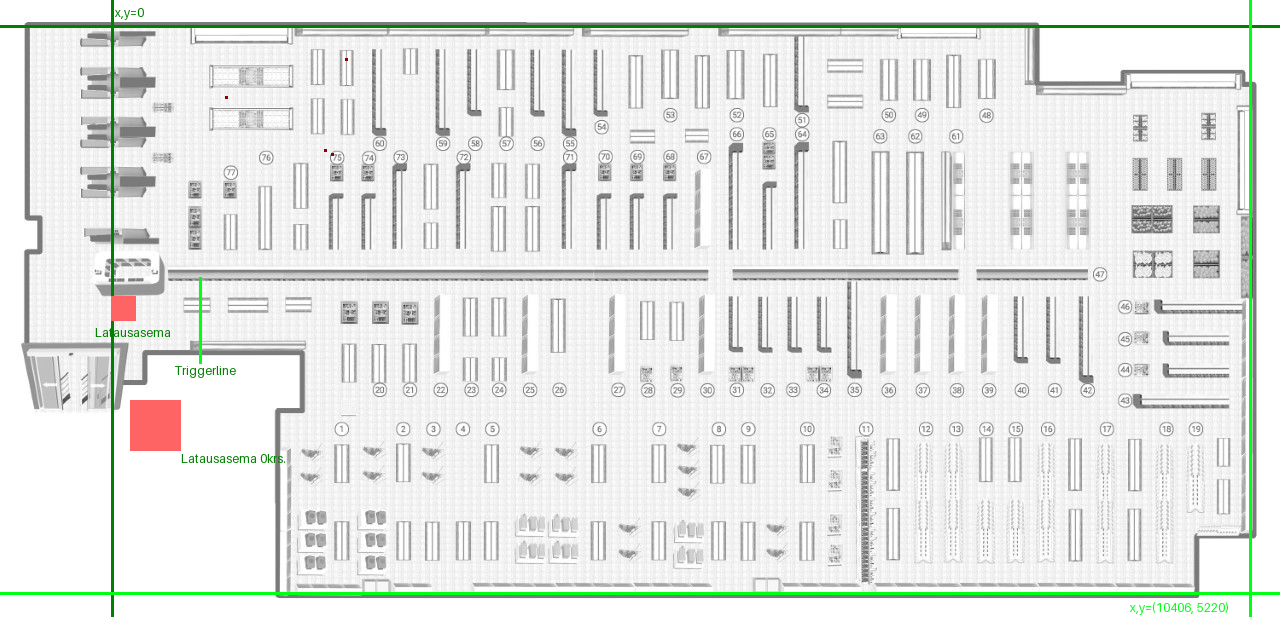

(122.1047619047619, 296.3009708737864)


In [108]:
#piirrä kuvaan
draw(df_plot)


#y-akselin väärien arvojen löytäminen
#test= df_lim[(df_lim['y'] < 200) & (df_lim['y'] > 100)]
#test= df_lim[df_lim['y'] > 4900]

In [ ]:
#test.describe()

#test[test['y'] == 5050].count()

